# Problem Statement
      To detect and recognise the traffic signs with Convolution Neural Network and 
      Tensorflow.
    
    
## Libraries Used 
1. Pickle
The pickle module implements binary protocols for serializing and de-serializing a Python object structure. “Pickling” is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, whereby a byte stream (from a binary file or bytes-like object) is converted back into an object hierarchy.

2. Matplotlib
Matplotlib is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

3. Pandas
Pandas is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

4. Numpy
NumPy is the fundamental package for scientific computing with Python.It contains a powerful N-dimensional array objects.

5. Tensorflow
TensorFlow is an open source software library for numerical computation using data flow graphs.

## Load The Data

In [1]:
# Load pickled data
import pickle
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
from matplotlib import gridspec

training_file = './train.p'  
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

## Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


In [2]:
import numpy as np

n_train = len(X_train) #Number of training examples


n_test = len(X_test) # Number of testing examples.


image_shape = X_train.shape

n_classes = len(np.unique(y_train))#unique classes/labels in the dataset.


print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


LEARNING_RATE = 0.001
REG_PARAM = 1e-5
BATCH_SIZE = 128
EPOCHS = 10

DEV_DATA_PERCENTAGE = 0.1

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (39209, 32, 32, 3)
Number of classes = 43


### Utility function for displaying images.    
    display_images() function
### Function  used to plot the distribution of training examples amongst classes.
    draw_class_distribution()


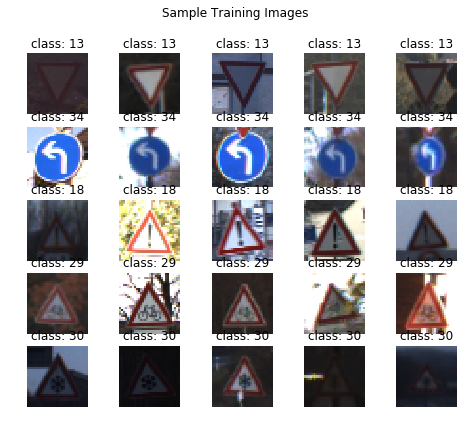

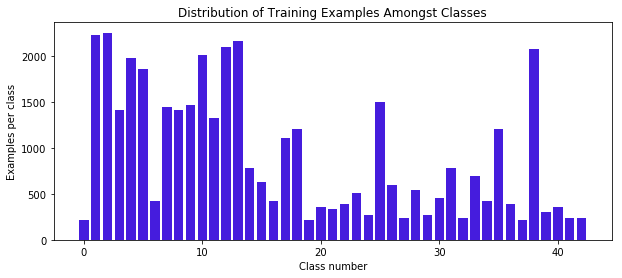

(39209, 32, 32, 3)


In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import cv2
import util



def display_images(image_dataset, n_rows, n_cols, graph_title='Sample Training Images'):
    
    plt.figure(figsize=(8, 6.5))
    selected_classes = np.random.randint(44, size=n_rows)
    image_number = 1
    for row in selected_classes:
        for col in range(1, n_cols + 1):
            plt.subplot(n_rows, n_cols, image_number)
            image_number += 1
            x_selected = X_train[y_train == row]
            random_index = np.random.randint(x_selected.shape[0])
            plt.imshow(x_selected[random_index, :, :, :]) 
            plt.axis('off')
            plt.title('class: {}'.format(row))  
    plt.suptitle(graph_title)
    plt.show()
    
    
def draw_class_distribution(class_labels):
    plt.figure(figsize=(10, 4))
    examples_per_class = np.bincount(class_labels)
    num_classes = len(examples_per_class)
    plt.bar(np.arange(num_classes), examples_per_class, 0.8, color='#451cdd', label='Inputs per class')
    plt.xlabel('Class number')
    plt.ylabel('Examples per class')
    plt.title('Distribution of Training Examples Amongst Classes')
    plt.show()   
    
display_images(X_train, 5, 5)
draw_class_distribution(y_train)
print(X_train.shape)

##  Design Of Model Architecture

1. Normalized data helps Gradient Descent (or similar algorithms) to converge quickly. Hence, data normalization is one of the key preprocessing steps when it comes to data preprocessing. I experimented with preprocessing techniques (namely, **MinMax Scaling** and **Mean Normalization**). But during the initial stage of the project, I found out that, MinMax Scaling works better than  Mean Normalization for this dataset. 
2. **One-Hot Encoding** was used to convert label numbers to vectors. 
3. A small percentage of training data (indicated by **DEV_DATA_PERCENTAGE**) was used as my development set.

In [4]:
# Step: 1 Mix-Max Normalization
X_train_maxmin = util.min_max_normalization(X_train)
X_test_maxmin = util.min_max_normalization(X_test)

# Step: 2 One-Hot-Encoding
y_train, y_test = util.one_hot_encoding(y_train, y_test)

# Step: 3 train and dev split
train_features, dev_features, train_labels, dev_labels = util.train_dev_split(
    X_train_maxmin, y_train, DEV_DATA_PERCENTAGE)

training_dataset = util.DataSet(train_features, train_labels)
dev_dataset = util.DataSet(dev_features, dev_labels)
testing_dataset = util.DataSet(X_test_maxmin, y_test)

## Basic steps to train a neural network:-
1. Sample a batch of data
2. Forward propogation it through graph and get the loss
3. Back propogate to calculate gradient
4. Update the parameters using the gradient
    
### Why to use Activation function?
Entire neural network ends up being a linear sandwich and your capacity is equal to that of the linear classifier and it helps to fit your data.
    
### Activation functions
1. Sigmoid
    A sigmoid function is a mathematical function having a characteristic "S"-shaped curve     or sigmoid curve.
    It has some drawbacks:-
      1.1 Saturated neurons kill gradient through back propogation.
      1.2 Outputs are not zero centred.
        
      eg:- When you have large network of sigmoid neurons in a saturated regime,
      then gradients can back propogate.
             
2. Tanh(x)
    It squashes numbers to range [-1,1].Also it is zero centred and kills gradients when
    saturated.
    
    
3. Relu(Rectified Linear Unit)
 3.1 Relu does not saturate in positive region.
 3.2 Very computationally effecient.
 3.3 Faster than sigmoid and tanh.

## Convolution Neural Network
 Convolutional Neural Networks are very similar to ordinary Neural Networks They are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity.
 
### Layers in Convolution Neural Network
1. Convolution
      Convolutional layers apply a convolution operation to the input, passing the result
      to the next layer.

2. Pooling
      Pooling layer makes representation smaller and more managable and operates each 
      activation map independently.
 2.1 Max Pooling
    Typical values are 2x2. Very large input volumes may warrant 4x4 pooling 
    the lower-layers. However, choosing larger shapes will dramatically reduce
    the dimension of the signal, and may result in excess information loss.
    Often, non-overlapping pooling windows perform best.

3. Fully Connected
      Fully connected layers connect every neuron in one layer to every neuron in another 
      layer. It is in principle the same as the traditional multi-layer perceptron neural 
      network.
      
4. Loss Layer
      The loss layer specifies how training penalizes the deviation between the predicted 
      and true labels and is normally the final layer. Various loss functions appropriate 
      for different tasks may be used there.
 
### LeNet architecture
   conv-pool-conv-pool-conv-fully connected.
### LeNet has the following configuration.
  1. First convolutional layer: 5x5 kernel, stride of 1, depth of 6, VALID padding.
  2. Max pooling layer: 2x2 kernal with stride of 2
  3. Second convolutional layer: 5x5 kernel, stride of 1, depth of 16, VALID padding.
  4. Max pooling layer: 2x2 kernal with stride of 2
  5. Fully connected layer of size 1024
  6. Dropout layer with dropout probability 0.5
  7. Fully connected layer of size 1024
  8. Dropout layer with dropout probability 0.5
  9. Finally, a softmax layer with size 43
   
### Stochastic gradient descent
Stochastic gradient descent also known as incremental gradient descent, is a stochastic approximation of the gradient descent optimization method for minimizing an objective function that is written as a sum of differentiable functions. In other words, SGD tries to find minima or maxima by iteration. 
### Adam Optimizer
Adam is an optimization algorithm that can used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.
tf.train.AdamOptimizer().

### Parameters used
1. Optimizer: AdamOptimizer
2. Learning Rate: 1e-3
3. Epochs:  100
4. Batch Size: 128
5. Regularization Parameter: 1e-6

Epoch:0 train loss:2.0280 dev loss:2.1818 train accu:0.3672 dev accu:0.3133
Epoch:2 train loss:0.4978 dev loss:0.6276 train accu:0.8516 dev accu:0.7948
Epoch:4 train loss:0.1462 dev loss:0.2309 train accu:0.9688 dev accu:0.9307
Epoch:6 train loss:0.2086 dev loss:0.1275 train accu:0.9609 dev accu:0.9646
Epoch:8 train loss:0.0718 dev loss:0.1016 train accu:0.9844 dev accu:0.9747
Trained model saved to the disk.


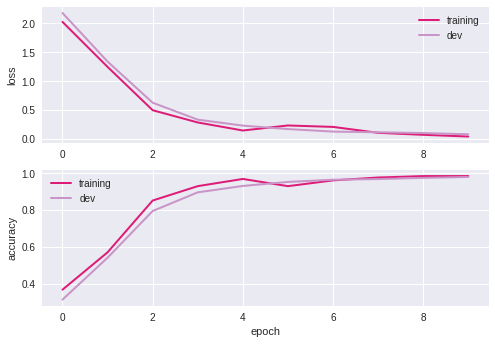

In [5]:
NUM_CLASSES = 43

LEARNING_RATE = 1e-3

EPOCHS = 10

BATCH_SIZE = 128

TRAINING_FILE = './data/train.p'

TESTING_FILE = './data/test.p'

REGULARIZATION_PARAM = 1e-6

MODEL_NAME = './checkpoint_lenetplus/LeNetPlus.ckpt'

def LeNetPlus(data):
    # first conv layer
    with tf.name_scope('conv_1'):
        conv1_w = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), stddev = 0.01))
        conv1_b = tf.Variable(tf.zeros(6))
        conv1 = tf.nn.conv2d(x, conv1_w, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
        conv1 = tf.nn.relu(conv1)
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
    # second conv layer
    with tf.name_scope('conv_2'):
        conv2_w = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), stddev = 0.01))
        conv2_b = tf.Variable(tf.zeros(16))
        conv2 = tf.nn.conv2d(conv1, conv2_w, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
        conv2 = tf.nn.relu(conv2)
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
    # first fully connected layer
    with tf.name_scope('fc_1'):
        fc1 = flatten(conv2)
        fc1_shape = (fc1.get_shape().as_list()[-1], 1024)
        fc1_w = tf.Variable(tf.truncated_normal(shape=(fc1_shape), stddev = 0.01))
        fc1_b = tf.Variable(tf.zeros(1024))
        fc1 = tf.matmul(fc1, fc1_w) + fc1_b
        fc1 = tf.nn.relu(fc1)
        fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # second fully connected layer
    with tf.name_scope('fc_2'):
        fc2_w = tf.Variable(tf.truncated_normal(shape=(1024, 1024), stddev=0.01))
        fc2_b = tf.Variable(tf.zeros(1024))
        fc2 = tf.matmul(fc1, fc2_w) + fc2_b
        fc2 = tf.nn.relu(fc2)
        fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # logit 
    with tf.name_scope('logit'):
        logit_w = tf.Variable(tf.truncated_normal(shape=(1024, NUM_CLASSES), stddev = 0.01))
        logit_b = tf.Variable(tf.zeros(NUM_CLASSES))
        return (tf.matmul(fc2, logit_w) + logit_b), [conv1_w, conv2_w, fc1_w, fc2_w, logit_w] 
    
def regularization_cost(weights, regularization):
    reg_cost = 0.0
    for weight in weights:
        reg_cost += regularization * tf.nn.l2_loss(weight)
    return reg_cost

# placeholders for input images, labels and dropout percentage
x = tf.placeholder("float", [None, 32, 32, 3])
tf.add_to_collection("x", x) 

y = tf.placeholder("float", [None, NUM_CLASSES])
tf.add_to_collection("y", y) 

keep_prob = tf.placeholder(tf.float32)
tf.add_to_collection("keep_prob", keep_prob) 

logits, weights = LeNetPlus(x)
tf.add_to_collection("logits", logits)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y)) + \
          regularization_cost(weights, REGULARIZATION_PARAM)
tf.add_to_collection('loss_op', loss_op)

optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
train_op = optimizer.minimize(loss_op)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.add_to_collection('accuracy_op', accuracy_op)

def eval_data(dataset):
    steps_per_epoch = dataset.length() // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    total_acc, total_loss = 0, 0
    for step in range(steps_per_epoch):
        batch_x, batch_y = dataset.next_batch(BATCH_SIZE)
        loss, acc = sess.run([loss_op, accuracy_op], 
                             feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
    return total_loss / num_examples, total_acc / num_examples

saver = tf.train.Saver()
best_dev_acc = 1e-10

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    steps_per_epoch = len(train_features) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    
    training_accuracies = []
    dev_accuracies = []

    training_losses = []
    dev_losses = []
    
    for epoch in range(EPOCHS):
        
        for step in range(steps_per_epoch):
            batch_x, batch_y = training_dataset.next_batch(BATCH_SIZE)
            loss, accur = sess.run([train_op, accuracy_op],
                                   feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})        
        
        # training loss and accuracy after an epoch
        loss_tr, acc_tr = sess.run([loss_op, accuracy_op], 
                                   feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})        
        training_losses.append(loss_tr)
        training_accuracies.append(acc_tr)

        loss_dev, acc_dev = eval_data(dev_dataset)
        dev_accuracies.append(acc_dev)
        dev_losses.append(loss_dev)
        
        if acc_dev > best_dev_acc:                
                saver.save(sess, MODEL_NAME, global_step=step)
                best_dev_acc = acc_dev
        
        if epoch % 2 == 0:
            print('Epoch:{:d} train loss:{:.4f} dev loss:{:.4f} train accu:{:.4f} dev accu:{:.4f}'.format(
                    epoch, loss_tr, loss_dev, acc_tr, acc_dev))      
    
    print('Trained model saved to the disk.')
    util.plot_learning_curves(training_losses, training_accuracies, dev_losses, dev_accuracies)

### Augmented Images
For each image to the training dataset, small random Rotation, Translation and Shear operation was applied. So by using this approach I was able to double my training dataset. 

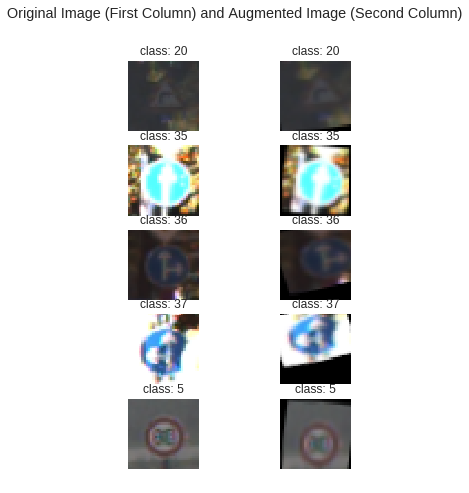

In [6]:
def display_augmented_images(image_dataset, augmented_data, n_rows):
    plt.figure(figsize=(5,7.5))
    selected_classes = np.random.randint(0, 44, size=n_rows)
    image_number = 1
    for row in selected_classes:
        x_selected = X_train[np.argmax(y_train, axis=1) == row]
        index = 0 # print first image of each image category
        
        plt.subplot(n_rows, 2, image_number)
        plt.imshow(x_selected[index, :, :, :]) 
        plt.axis('off')
        plt.title('class: {}'.format(row)) 
        image_number += 1
        
        aug_selected = augmented_data[np.argmax(y_train, axis=1) == row]
        
        plt.subplot(n_rows, 2, image_number)
        plt.imshow(aug_selected[index, :, :, :]) 
        plt.axis('off')
        plt.title('class: {}'.format(row))
        image_number += 1
        
    plt.suptitle('Original Image (First Column) and Augmented Image (Second Column)')
    plt.show()
    
    
X_train_transformed = np.zeros_like(X_train)
y_train_transformed = np.zeros_like(y_train)

for i in range(X_train_transformed.shape[0]): #
    X_train_transformed[i] = util.transform_image(X_train[i], 20, 10, 5)
    y_train_transformed[i] = y_train[i]        

display_augmented_images(X_train, X_train_transformed, 5)

In [7]:
with tf.Session(graph = tf.Graph()) as sess:
    saver = tf.train.import_meta_graph('./checkpoint_lenetplus/LeNetPlus.ckpt-274.meta')
    saver.restore(sess,  tf.train.latest_checkpoint('./checkpoint_lenetplus'))
        
    # Retrieve the Ops we 'remembered'.
    x = tf.get_collection("x")[0]
    y = tf.get_collection("y")[0]
    keep_prob = tf.get_collection("keep_prob")[0]
    logits = tf.get_collection('logits')[0]
    accuracy_op = tf.get_collection('accuracy_op')[0]
    loss_op = tf.get_collection('loss_op')[0]
        
    model_loss, model_perf = eval_data(testing_dataset)
    print('Test Dataset Classification Accuracy: {:.4f}'.format(model_perf))

INFO:tensorflow:Restoring parameters from ./checkpoint_lenetplus/LeNetPlus.ckpt-274
Test Dataset Classification Accuracy: 0.9214


In [8]:
with tf.Session(graph = tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        './checkpoint_64_64_128_1024_1024/LeNetPlusPlus_64_64_128_1024_1024.ckpt-550.meta')
    saver.restore(sess,  tf.train.latest_checkpoint('./checkpoint_64_64_128_1024_1024'))
        
    # Retrieve the Ops we 'remembered'.
    x = tf.get_collection("x")[0]
    y = tf.get_collection("y")[0]
    keep_prob = tf.get_collection("keep_prob")[0]
    logit = tf.get_collection('logit')[0]
    accuracy_op = tf.get_collection('accuracy_op')[0]
    loss_op = tf.get_collection('loss_op')[0]
        
    model_loss, model_perf = eval_data(testing_dataset)
    print('Test Dataset Classification Accuracy: {:.4f}'.format(model_perf))

INFO:tensorflow:Restoring parameters from ./checkpoint_64_64_128_1024_1024/LeNetPlusPlus_64_64_128_1024_1024.ckpt-550
Test Dataset Classification Accuracy: 0.9662


## Step 3: Test a Model on New Images
Several pictures of traffic signs were used to test the classfication model.


In [9]:
import os
import scipy.misc

NEW_IMAGES_FOLDER = './new_images/'

labels = {0: '30',
          1: 'ss40',
          2: 'stop',
          3: 'tprior',
          4: 'turrn'
          }

def resize_image(image_file):
    image = plt.imread(NEW_IMAGES_FOLDER + image_file)
    return scipy.misc.imresize(image, (32,32))

resized_image_data = [(resize_image(image), image[:-4]) 
                          for image in os.listdir(NEW_IMAGES_FOLDER)]

INFO:tensorflow:Restoring parameters from ./checkpoint_64_64_128_1024_1024/LeNetPlusPlus_64_64_128_1024_1024.ckpt-550


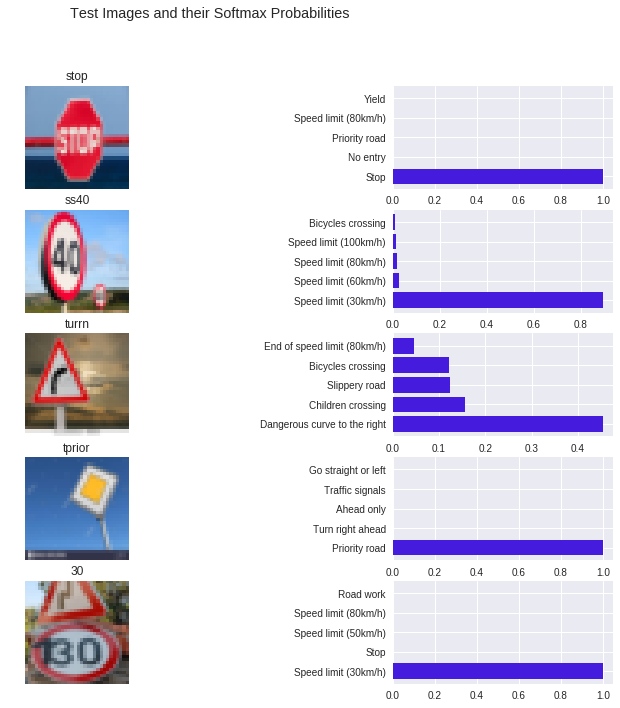

In [10]:
resized_images = [img_and_name[0] for img_and_name in resized_image_data]
X_test_new_dataset = util.min_max_normalization(np.array(resized_images))

def print_result(ground_truth, top_k_prob, top_k_indices):
    class_names = pd.read_csv('./data/signnames.csv')['SignName'].values
    index = 0
    img_index = 0
    plt.figure(figsize=(14, 11))
    gs = gridspec.GridSpec(5, 2, width_ratios=[1, 0.45]) 
    for key in ground_truth:
        img, tag = resized_image_data[img_index]
        img_index += 1
        plt.subplot(gs[index])
        plt.imshow(img)
        plt.axis('off')
        plt.title(tag)
        index += 1

        plt.subplot(gs[index])
        plt.barh(np.arange(1, 6, 1), 
                 top_k_prob[key, :],
                 0.8, 
                 color='#451cdd')
        plt.yticks(np.arange(1, 6, 1), class_names[top_k_indices[key, :]])
        index += 1
    plt.suptitle('Test Images and their Softmax Probabilities')
    plt.show()
    
    

with tf.Session(graph = tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        './checkpoint_64_64_128_1024_1024/LeNetPlusPlus_64_64_128_1024_1024.ckpt-550.meta')
    saver.restore(sess,  tf.train.latest_checkpoint('./checkpoint_64_64_128_1024_1024'))
        
    # Retrieve the Ops 
    x = tf.get_collection("x")[0]
    y = tf.get_collection("y")[0]
    keep_prob = tf.get_collection("keep_prob")[0]
    logits = tf.get_collection('logit')[0]
    softmax = tf.nn.softmax(logits)
    normalized_prob = sess.run(softmax, feed_dict={x: X_test_new_dataset, keep_prob: 1.0})    
    top_k_op = tf.nn.top_k(normalized_prob, k=5)
    top_k_results = sess.run(top_k_op)
    
    # show predictions with their probabilities
    print_result(labels, top_k_results.values, top_k_results.indices)

## Improvements
This module recognizes traffic signs when inputs provided are images.Exploring techniques to implement this module when the input is a video feed.

## References
1. www.numpy.org
2. www.tensorflow.org
3. http://cs231n.github.io/convolutional-networks/
4. https://www.youtube.com/channel/UCPk8m_r6fkUSYmvgCBwq-sw/playlists